In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import style
style.use('ggplot')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import numpy as np
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data = pd.read_csv('IMDB_Dataset.csv')

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.shape

(50000, 2)

Text(0.5, 1.0, 'sentiment distribution')

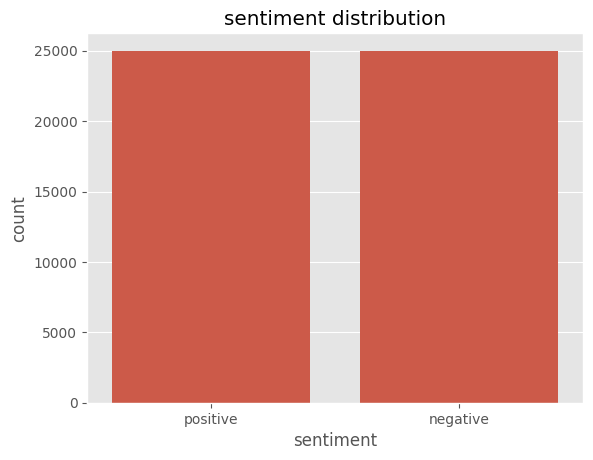

In [ ]:
sns.countplot(x='sentiment',data=data)
plt.title("sentiment distribution")

In [ ]:
def no_of_words(text):
  words=text.split()
  return len(words)

In [ ]:
data['word_count']=data['review'].apply(no_of_words)
data.head()

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


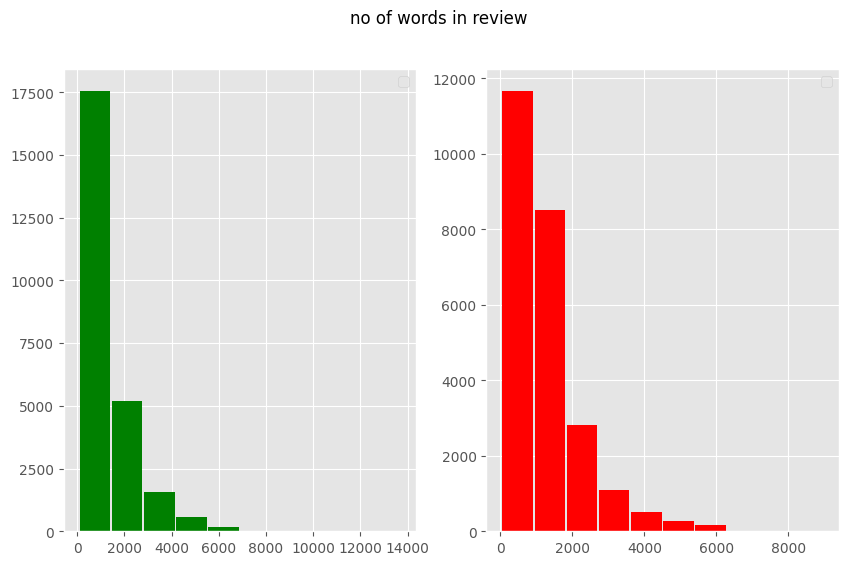

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].hist(data[data['sentiment']=='positive']['review'].str.len(),color='green',rwidth=0.95)
ax[0].legend(loc='upper right')
ax[1].hist(data[data['sentiment']=='negative']['review'].str.len(),color='red',rwidth=0.95)
ax[1].legend(loc='upper right')
fig.suptitle('no of words in review')
plt.show()

In [ ]:
data.sentiment.replace('positive',1,inplace=True)
data.sentiment.replace('negative',0,inplace=True)
data.head()

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


In [ ]:
def data_processing(text):
  text=text.lower()
  # text=text.replace('<br />',' ')
  text=re.sub('<br\s*/?>',' ',text)
  text=re.sub(r'https\S+|www\S+|http\S+','',text,flags=re.MULTILINE)
  text=re.sub(r'[^\w\s]','',text)
  text=re.sub(r'\@w+|\#','',text)
  text=word_tokenize(text)
  text=[word for word in text if word not in stopwords]
  text=' '.join(text)
  return text

In [ ]:
data['review'] = data['review'].apply(data_processing)
data.head()

,review,sentiment,word_count
0,one reviewers mentioned watching 1 oz episode ...,1,307
1,wonderful little production filming technique ...,1,162
2,thought wonderful way spend time hot summer we...,1,166
3,basically theres family little boy jake thinks...,0,138
4,petter matteis love time money visually stunni...,1,230


In [ ]:
duplicate_count = data.duplicated().sum()
print('Number of duplicate rows:', duplicate_count)

Number of duplicate rows: 421


In [ ]:
data=data.drop_duplicates('review')

In [ ]:
data.duplicated().sum()

0

In [ ]:
stemmer=PorterStemmer()
def stemming(dat):
  text=[stemmer.stem(word) for word in dat]
  return dat

In [ ]:
data.review=data.review.apply(lambda x: stemming(x))

In [ ]:
data['word_count_after_stemming']=data['review'].apply(no_of_words)
data.head()

,review,sentiment,word_count,word_count_after_stemming
0,one reviewers mentioned watching 1 oz episode ...,1,307,167
1,wonderful little production filming technique ...,1,162,84
2,thought wonderful way spend time hot summer we...,1,166,86
3,basically theres family little boy jake thinks...,0,138,69
4,petter matteis love time money visually stunni...,1,230,125


In [ ]:
pos_reviews=data[data['sentiment']==1]
neg_reviews=data[data['sentiment']==0]

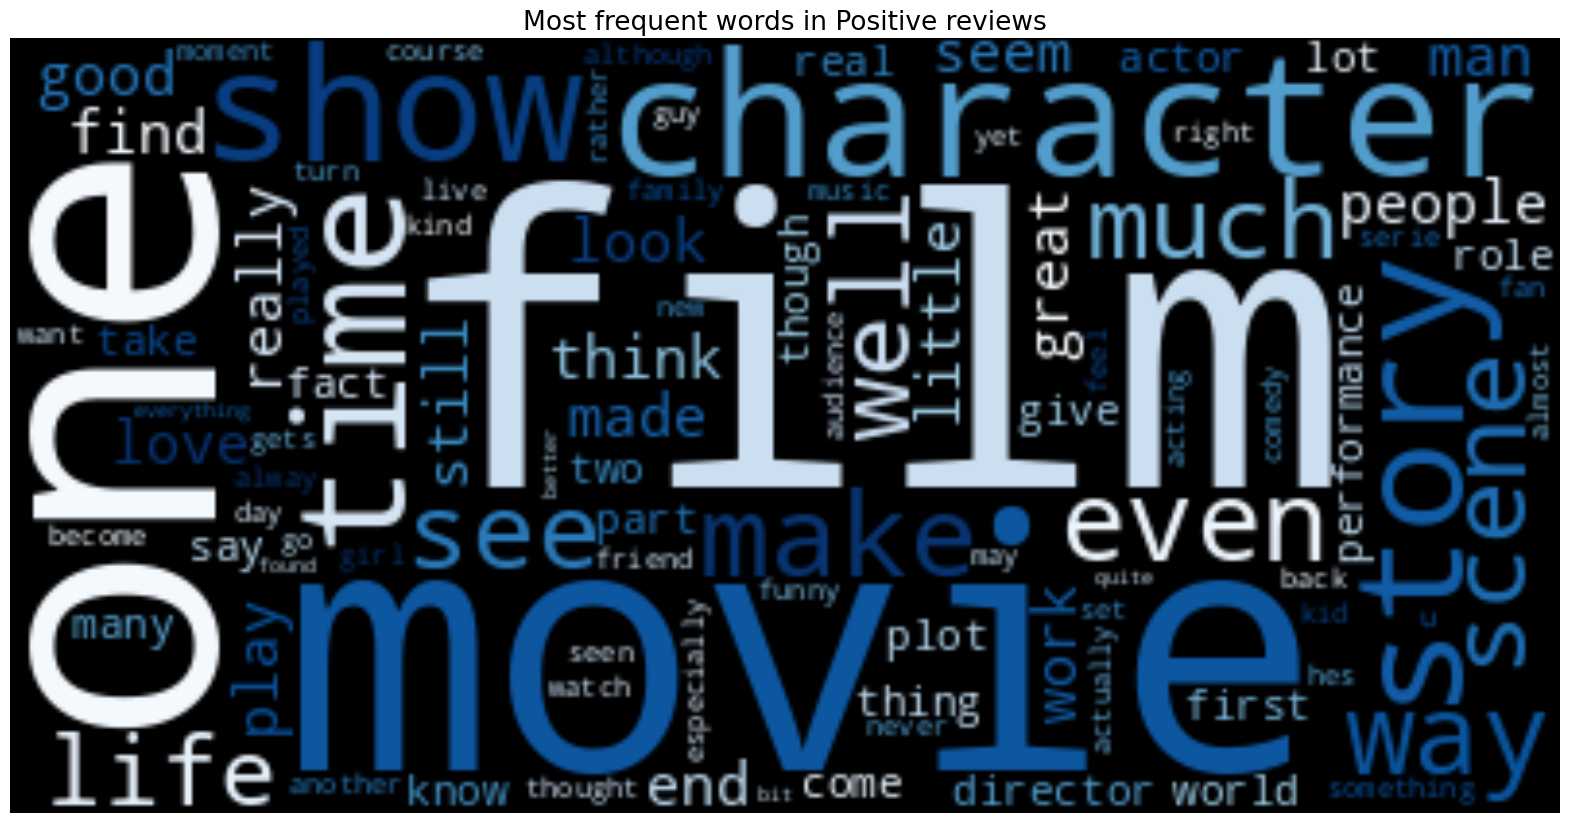

In [ ]:
text=' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud=WordCloud(max_words=100,colormap='Blues').generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Positive reviews',fontsize = 19)
plt.show()

In [ ]:
from collections import Counter
count=Counter()
for text in pos_reviews['review'].values:
  for word in text.split():
    count[word]+=1
count.most_common(15)

[('film', 40024),
 ('movie', 36511),
 ('one', 26182),
 ('like', 17122),
 ('good', 14507),
 ('great', 12734),
 ('story', 12572),
 ('time', 12074),
 ('see', 11935),
 ('well', 11362),
 ('also', 10694),
 ('really', 10682),
 ('would', 10335),
 ('even', 9437),
 ('much', 9070)]

In [ ]:
pos_words=pd.DataFrame(count.most_common(15),columns=['word','count'])
pos_words.head()

,word,count
0,film,40024
1,movie,36511
2,one,26182
3,like,17122
4,good,14507


In [ ]:
fg=px.bar(pos_words,x='word',y='count',color='word',title='Most frequent words in Positive reviews')
fg.show()

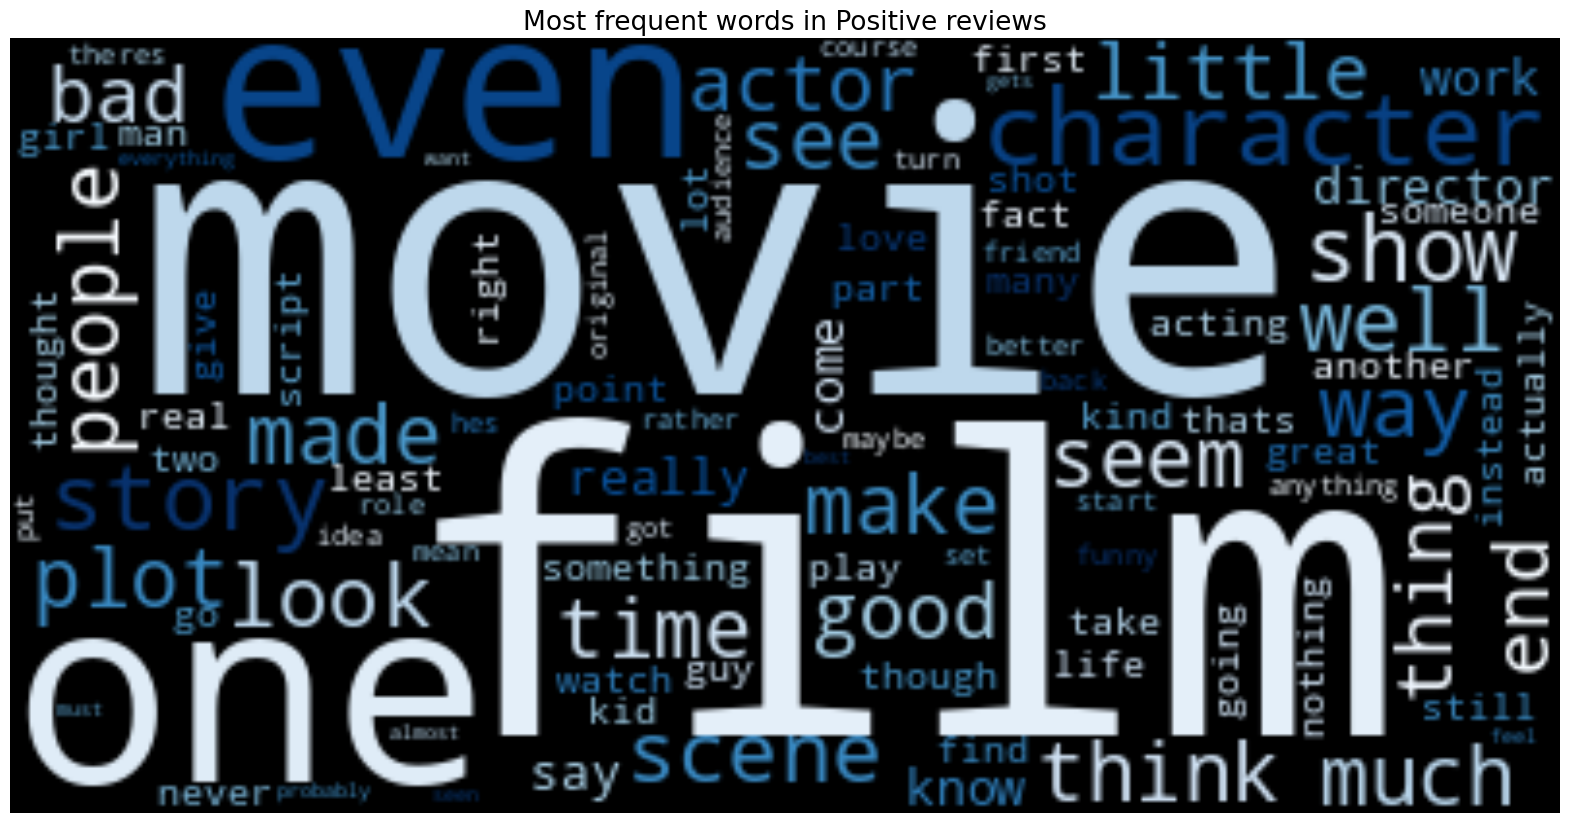

In [ ]:
text=' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud=WordCloud(max_words=100,colormap='Blues').generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Positive reviews',fontsize = 19)
plt.show()

In [ ]:
from collections import Counter
count=Counter()
for text in neg_reviews['review'].values:
  for word in text.split():
    count[word]+=1
count.most_common(15)

[('movie', 48022),
 ('film', 35468),
 ('one', 24901),
 ('like', 21619),
 ('even', 14938),
 ('bad', 14196),
 ('good', 14193),
 ('would', 13502),
 ('really', 12155),
 ('time', 11688),
 ('see', 10498),
 ('dont', 10157),
 ('get', 9920),
 ('much', 9872),
 ('story', 9792)]

In [ ]:
neg_words=pd.DataFrame(count.most_common(15),columns=['word','count'])
neg_words.head()

,word,count
0,movie,48022
1,film,35468
2,one,24901
3,like,21619
4,even,14938


In [ ]:
fg=px.bar(neg_words,x='word',y='count',color='word',title='Most frequent words in Positive reviews')
fg.show()

In [ ]:
x=data['review']
y=data['sentiment']
x.head()

0    one reviewers mentioned watching 1 oz episode ...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
4    petter matteis love time money visually stunni...
Name: review, dtype: object

In [ ]:
vector=TfidfVectorizer()
x=vector.fit_transform(x)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [ ]:
x_train.shape

(34702, 166864)

In [ ]:
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
logreg_pred=logreg.predict(x_test)
logreg_acc=accuracy_score(y_test,logreg_pred)
print('Accuracy of Logistic Regression:',logreg_acc*100)

Accuracy of Logistic Regression: 89.64566664425469


In [ ]:
print(confusion_matrix(y_test,logreg_pred))
print()
print(classification_report(y_test,logreg_pred))

[[6551  856]
 [ 684 6782]]

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      7407
           1       0.89      0.91      0.90      7466

    accuracy                           0.90     14873
   macro avg       0.90      0.90      0.90     14873
weighted avg       0.90      0.90      0.90     14873



In [ ]:
mnb=MultinomialNB()
mnb.fit(x_train,y_train)
mnb_pred=mnb.predict(x_test)
mnb_acc=accuracy_score(y_test,mnb_pred)
print('Accuracy of Logistic Regression:',mnb_acc*100)

Accuracy of Logistic Regression: 86.76124520943993


In [ ]:
print(confusion_matrix(y_test,mnb_pred))
print()
print(classification_report(y_test,mnb_pred))

[[6500  907]
 [1062 6404]]

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      7407
           1       0.88      0.86      0.87      7466

    accuracy                           0.87     14873
   macro avg       0.87      0.87      0.87     14873
weighted avg       0.87      0.87      0.87     14873



In [ ]:
svc=LinearSVC()
svc.fit(x_train,y_train)
svc_pred=svc.predict(x_test)
svc_acc=accuracy_score(y_test,svc_pred)
print('Accuracy of Logistic Regression:',svc_acc*100)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



Accuracy of Logistic Regression: 89.74652054057688


In [ ]:
print(confusion_matrix(y_test,svc_pred))
print()
print(classification_report(y_test,svc_pred))

[[6598  809]
 [ 716 6750]]

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7407
           1       0.89      0.90      0.90      7466

    accuracy                           0.90     14873
   macro avg       0.90      0.90      0.90     14873
weighted avg       0.90      0.90      0.90     14873



In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100],'loss':['hinge','squared_hinge']}
grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 1/5] END .................C=0.1, loss=hinge;, score=0.876 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 2/5] END .................C=0.1, loss=hinge;, score=0.880 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 3/5] END .................C=0.1, loss=hinge;, score=0.883 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 4/5] END .................C=0.1, loss=hinge;, score=0.874 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 5/5] END .................C=0.1, loss=hinge;, score=0.876 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 1/5] END .........C=0.1, loss=squared_hinge;, score=0.893 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 2/5] END .........C=0.1, loss=squared_hinge;, score=0.896 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 3/5] END .........C=0.1, loss=squared_hinge;, score=0.898 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 4/5] END .........C=0.1, loss=squared_hinge;, score=0.892 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 5/5] END .........C=0.1, loss=squared_hinge;, score=0.892 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 1/5] END ...................C=1, loss=hinge;, score=0.894 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 2/5] END ...................C=1, loss=hinge;, score=0.896 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 3/5] END ...................C=1, loss=hinge;, score=0.900 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 4/5] END ...................C=1, loss=hinge;, score=0.894 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 5/5] END ...................C=1, loss=hinge;, score=0.894 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 1/5] END ...........C=1, loss=squared_hinge;, score=0.893 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 2/5] END ...........C=1, loss=squared_hinge;, score=0.892 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 3/5] END ...........C=1, loss=squared_hinge;, score=0.898 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 4/5] END ...........C=1, loss=squared_hinge;, score=0.891 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 5/5] END ...........C=1, loss=squared_hinge;, score=0.895 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 1/5] END ..................C=10, loss=hinge;, score=0.874 total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 2/5] END ..................C=10, loss=hinge;, score=0.875 total time=  14.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 3/5] END ..................C=10, loss=hinge;, score=0.880 total time=  14.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 4/5] END ..................C=10, loss=hinge;, score=0.875 total time=  14.3s
[CV 5/5] END ..................C=10, loss=hinge;, score=0.880 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 1/5] END ..........C=10, loss=squared_hinge;, score=0.879 total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 2/5] END ..........C=10, loss=squared_hinge;, score=0.878 total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 3/5] END ..........C=10, loss=squared_hinge;, score=0.882 total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 4/5] END ..........C=10, loss=squared_hinge;, score=0.879 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 5/5] END ..........C=10, loss=squared_hinge;, score=0.883 total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 1/5] END .................C=100, loss=hinge;, score=0.874 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 2/5] END .................C=100, loss=hinge;, score=0.874 total time=  13.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 3/5] END .................C=100, loss=hinge;, score=0.877 total time=  11.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 4/5] END .................C=100, loss=hinge;, score=0.876 total time=  14.2s
[CV 5/5] END .................C=100, loss=hinge;, score=0.880 total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 1/5] END .........C=100, loss=squared_hinge;, score=0.874 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 2/5] END .........C=100, loss=squared_hinge;, score=0.874 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 3/5] END .........C=100, loss=squared_hinge;, score=0.877 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 4/5] END .........C=100, loss=squared_hinge;, score=0.876 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[CV 5/5] END .........C=100, loss=squared_hinge;, score=0.880 total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge']},
             verbose=3)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'C': 1, 'loss': 'hinge'}
LinearSVC(C=1, loss='hinge')
0.8956544684780365


In [ ]:
svc=LinearSVC(C=1,loss='hinge')
svc.fit(x_train,y_train)
svc_pred=svc.predict(x_test)
svc_acc=accuracy_score(y_test,svc_pred)
print('Accuracy of Logistic Regression:',svc_acc*100)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



Accuracy of Logistic Regression: 89.84065084381093


In [ ]:
print(confusion_matrix(y_test,svc_pred))
print(classification_report(y_test,svc_pred))

[[6598  809]
 [ 702 6764]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7407
           1       0.89      0.91      0.90      7466

    accuracy                           0.90     14873
   macro avg       0.90      0.90      0.90     14873
weighted avg       0.90      0.90      0.90     14873



In [ ]:
import pickle
pickle.dump(svc,open('Movie_Review.pkl','wb'))